In [2]:
import sys
sys.path.append('/home/ivan/distribution_connector')
import os

from sklearn.decomposition import TruncatedSVD

import torch.nn.functional as F

In [3]:
from sklearn import datasets
import numpy as np
import torch
from tqdm import tqdm
from connector_utils import test_models, gather_statistics, test_func
import matplotlib.pyplot as plt

In [4]:
import torch as th

th.cuda.set_device(1)

In [5]:
from connector import Connector
# from one_layer_utils import samples, make_dataset, get_model, get_b
from utils import test_model
from utils import test as t

In [94]:
model_name = 'Linear3NoBias' # VGG16 Linear3NoBias

import models
architecture = getattr(models, model_name) #LinearOneLayer LogRegression

import data
loaders, num_classes = data.loaders(
    "CIFAR10",
    "data",
    128,
    1,
    "VGG",
    True,
    train_random=False,
    shuffle_train=False)

model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)

model1.load_state_dict(torch.load('curves/'+model_name+'/curve3/checkpoint-400.pt')['model_state'])
model2.load_state_dict(torch.load('curves/'+model_name+'/curve4/checkpoint-400.pt')['model_state'])


Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [95]:
model1.cuda();
model1.eval();
_, test = test_model(model1, loaders, cuda=True)

train results {'nll': 0.1488610157775879, 'loss': 0.1488610157775879, 'accuracy': 95.12}
test results {'nll': 2.03078635635376, 'loss': 2.03078635635376, 'accuracy': 62.54}


In [96]:
test['accuracy']

62.54

In [97]:
model2.cuda();
model2.eval();
test_model(model2, loaders, cuda=True)

train results {'nll': 0.14613401713371277, 'loss': 0.14613401713371277, 'accuracy': 95.278}
test results {'nll': 2.0166158367156983, 'loss': 2.0166158367156983, 'accuracy': 63.44}


({'nll': 0.14613401713371277, 'loss': 0.14613401713371277, 'accuracy': 95.278},
 {'nll': 2.0166158367156983, 'loss': 2.0166158367156983, 'accuracy': 63.44})

In [98]:
targ_test = []
for X, y in loaders['test']:
    targ_test.append(y)
targ_test = np.concatenate(targ_test)

targ_train = []
for X, y in loaders['train']:
    targ_train.append(y)
targ_train = np.concatenate(targ_train)

targ = {'train': targ_train, 'test': targ_test}

In [99]:
def get_pred(model, data_type='train'):
    model.cuda()
    model.eval()
    pred = []
    for X, y in loaders[data_type]: 
        pred.append(model(X.cuda()).cpu().data.numpy())
    
    pred = np.concatenate(pred)
    return pred

In [100]:
def get_funcs(model1, data='test', layer=0):
    model1.cuda()
    model1.eval()
    functions = []
    for X, y in loaders[data]:
        functions.append(model1(X.cuda(), N=layer).cpu().data.numpy())

    funcs = np.concatenate(functions)
    
    return funcs

def accuracy(pred, targ, verbose=False):
    ens_acc = 100.0 * np.mean(np.argmax(pred, axis=1) == targ)
    if verbose:
        print(ens_acc)
    return ens_acc

In [101]:
model1.load_state_dict(torch.load('curves/'+model_name+'/curve3/checkpoint-400.pt')['model_state'])
fbase_train = get_funcs(model1, data='train', layer=1)
fbase_test = get_funcs(model1, data='test', layer=1)

fbase = {'train': fbase_train, 'test': fbase_test}

In [104]:

data_type = 'test'
base = 'test'

fbase_inv = np.linalg.pinv(fbase[base].T)
layer = 1
m = architecture.base(num_classes=10, **architecture.kwargs)
funcs = []
Ws = []
bs = []
true_accuracy = []
cum_pred = 0
assemple_accuracy = []
beg = 3

for i in range(beg, 11):
    m.load_state_dict(torch.load('curves/'+model_name+'/curve'+str(i)+'/checkpoint-400.pt')['model_state'])
    m.cuda()
    pred = get_pred(m, data_type=data_type)
    cum_pred += pred
    true_accuracy.append(accuracy(pred, targ[data_type]))
    assemple_accuracy.append(accuracy(cum_pred, targ[data_type]))
    f = get_funcs(m, layer=layer, data=base)
    funcs.append(f)
    if 'VGG' in model_name:
        W = list(m.parameters())[-2].data.cpu().numpy()
        b = list(m.parameters())[-1].data.cpu().numpy()
    else:
        W = list(m.parameters())[-1].data.cpu().numpy()
        b = 0
    Ws.append(W)
    bs.append(b)
    
    

In [105]:
Ws[0].shape, funcs[0].shape

((10, 2000), (10000, 2000))

In [106]:
single_VGG = []
Wsn = []
for i in range(len(Ws)):
    Wsn.append(fbase_inv.T @ funcs[i] @ Ws[i].T)
    pred = fbase[data_type] @  Wsn[i] + bs[i]
    single_VGG.append(accuracy(pred, targ[data_type], verbose=False))

In [107]:
Assembled_VGG = []
# beg = 3

for l in range(1, 11-beg+1):

    Assemble_W_basis = 0
    Assemble_bias = np.array(bs[:l]).mean(0)

    for i in range(l):
        Assemble_W_basis += Wsn[i]

    Assemble_W_basis /= l

    pred = fbase[data_type] @ Assemble_W_basis + Assemble_bias
    Assembled_VGG.append(accuracy(pred, targ[data_type], verbose=False))



In [108]:
import matplotlib.pyplot as plt

In [109]:
Assembled_VGG

[62.53999999999999,
 63.72,
 64.36,
 64.4,
 64.63,
 64.57000000000001,
 64.75999999999999,
 64.73]

In [110]:
assemple_accuracy

[62.53999999999999, 65.29, 66.06, 66.69, 66.7, 66.88, 67.04, 67.25999999999999]

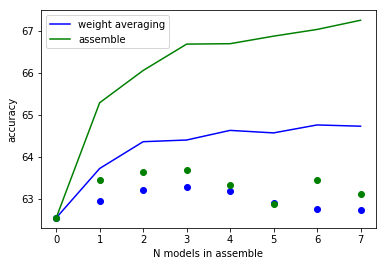

In [111]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 12, 8

plt.plot(Assembled_VGG, label='weight averaging', c='b')
plt.plot(assemple_accuracy, label='assemble', c='g') 
plt.plot(single_VGG, 'bo', c='b') #label='single model performance')
plt.plot(true_accuracy, 'bo', c='g') #, label='single model performancee')
plt.legend()
plt.xlabel('N models in assemble')
plt.ylabel('accuracy')
# plt.title(model_name)
plt.show()


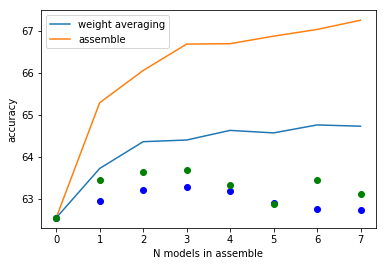

In [112]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 12, 8

plt.plot(Assembled_VGG, label='weight averaging')
plt.plot(assemple_accuracy, label='assemble') 
plt.plot(single_VGG, 'bo', c='b') #, label='single model performance with prseudo inverse')
plt.plot(true_accuracy, 'bo', c='g') #, label='single model performance')
plt.legend()
plt.xlabel('N models in assemble')
plt.ylabel('accuracy')
# plt.title('VGG16')
plt.show()


In [132]:
Assemble_W_basis.shape, Assemble_bias.shape, bs[0].shape

((512, 10), (10,), (10,))

In [133]:
# Assemble_W_basis = (alphas[0].T @ Ws[0].T+alphas[2].T @ Ws[2].T)/2 

In [134]:
pred = fbase @ betas.T @ Assemble_W_basis + Assemble_bias
accuracy(pred)

92.04
